In [1]:
pip install imutils #A series of convenience functions to make basic image processing functions

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=acf6ce7c9d0716f808c11eb5df6960166c9f0dec3ea68e22b42028c72f66b722
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow #intall tensorflow for deep learning models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


import cv2
import imutils

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras import layers
from keras.models import Model, Sequential 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, l1, l1_l2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

        
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-16 08:32:19.571038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 08:32:19.571159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 08:32:19.692748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# CONFIGURATION

In [4]:
class config:
    dir_data = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
    
    vgg16_dir = "/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    resnet50_dir = "/kaggle/input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
    
    
    seed = 42

# UTILS

# IMPORT LIBRARY

In [5]:
def load_data(dir_files:str = config.dir_data, 
              img_size:(int, int) = (224, 224)
             ):
    """
        This function creates X_train, X_valid, X_test, y_train, y_valid and y_test set and print labels as encoded
    
    """
    #Create empty list for X_train, X_valid, X_test
    X_train, X_val, X_test = [], [], []
    #Create empty list for y_train, y_valid, y_test
    y_train, y_val, y_test = [], [], []
    
    i = 0
    #Create dictionary to labels
    labels = dict()
    for path in sorted(os.listdir(dir_files)):
        if path.capitalize() == "No" or path.capitalize() == "Yes":
            #Add labels[0]: "No" and labels[1]: "Yes" to labels dict
            labels[i] = path.capitalize()
            #Calculate numebr of images each of has No and Yes Labels
            img_Count = len(os.listdir(os.path.join(dir_files, path)))
            
            for idx, filename in enumerate(os.listdir(os.path.join(dir_files, path))):
                if not filename.startswith("."):
                    #Read the images
                    img = cv2.imread(os.path.join(dir_files, path, filename))
                    #Resize the images
                    img = cv2.resize(img, img_size)
                    if idx < 5:
                        #Append images to X_test
                        X_test.append(img)
                        #Append i value to y_test
                        y_test.append(i)
                    elif idx <= img_Count * 0.8:
                        #Append images to X_train
                        X_train.append(img)
                        #Append images to y_train
                        y_train.append(i)
                        
                    else:
                        #Append images to X_val
                        X_val.append(img)
                        #Append i value to y_val
                        y_val.append(i)
            i += 1
    
    #Change list type to np.array for y_train, y_val, y_test
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    
    #Change list type to np.array for X_train, X_val, X_test
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    
    print(f"Labels encoded as: {labels}")
    print(f"\nTotal count of images are {len(y_train) + len(y_val) + len(y_test)}")
    print(f"\nTrain data set has {len(y_train)} images")
    print(f"\nValidation data set has {len(y_val)} images")
    print(f"\nTest data set has {len(y_test)} images")
    
    
    
    return X_train, y_train, X_val, y_val, X_test, y_test, labels 

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test, labels = load_data(img_size = (264, 264))

Labels encoded as: {0: 'No', 1: 'Yes'}

Total count of images are 253

Train data set has 194 images

Validation data set has 49 images

Test data set has 10 images


# EDA

## Count of Yes and No Labels

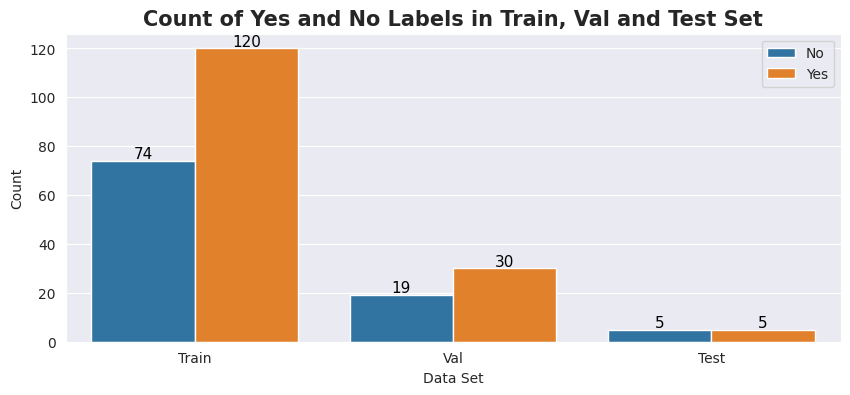

In [7]:
#Create dict for labels
y = {}
#Create lists in dictionary to add 0 and 1 Labels
y[0] = []
y[1] = []

for set_name in (y_train, y_val, y_test):
    #Add count of 0 labels to list
    y[0].append(np.sum(set_name ==0))
    #Add count of 1 labels to list
    y[1].append(np.sum(set_name ==1))

#Create dataframe to plot barplot
a = pd.DataFrame({
    
        "Count": y[0] + y[1],
        "No_yes": ["No", "No", "No", "Yes", "Yes", "Yes"],
        "Data Set": ["Train", "Val", "Test", "Train", "Val", "Test"]
    }
)

#Create figure for graph
plt.figure(figsize = (10, 4))
#Plot barplot 
sns.barplot(data = a, x = "Data Set", y = "Count", hue = "No_yes")
# Add count labels on top of each bar
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')


#Set title for graph
plt.title("Count of Yes and No Labels in Train, Val and Test Set", weight = "bold", fontsize = 15)
#Place a legend on figure
plt.legend()
#Display graph
plt.show()

- In the train set, mostly yes 

In [8]:
def plot_samples(
                X: np.array,
                y: np.array,
                n: int,
                labels: dict = labels
                
):

    """
        Show the n count of images as a sample
    
    """
    
    for index in range(len(labels)):
        #Take n count of images in X
        imgs = X[np.argwhere(y == index)][:n]
        
        j = 10
        i = int(n/j)
        
        #Create figure for images
        plt.figure(figsize = (15, 8))
        c = 1
        for img in imgs:
            #Use subplot for No and Yes labels
            plt.subplot(i, j, c)
            #Plot images
            plt.imshow(img[0])
            
            #Set x and y labels are empty
            plt.xticks([])
            plt.yticks([])
            #Increase c by 1
            c += 1
        
        #Set title for images
        plt.suptitle(f"Samples of Tumor: {labels[index]}")
        #Display images
        plt.show()

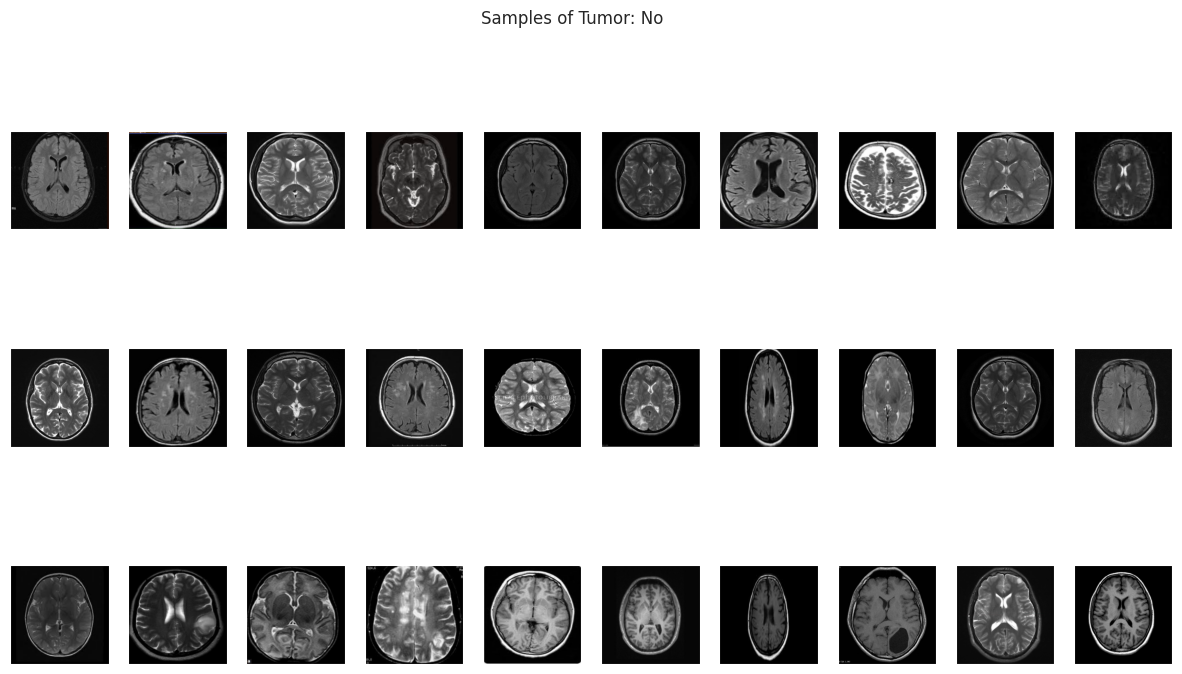

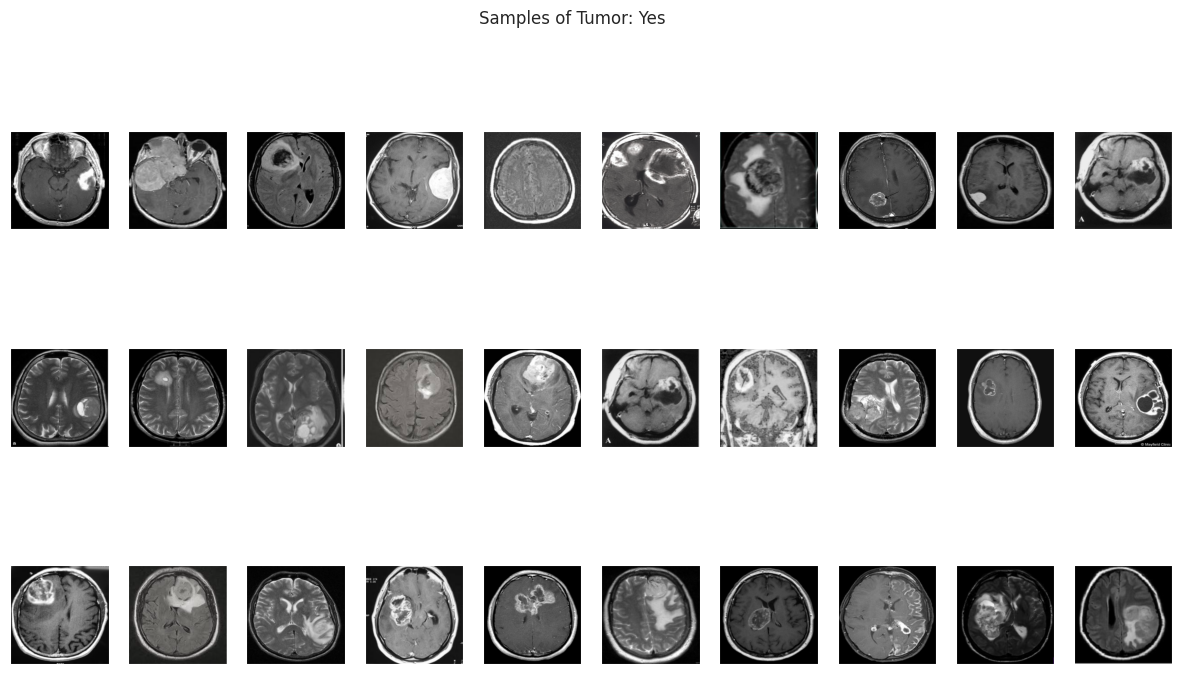

In [9]:
plot_samples(X_train, y_train, 30)

if you remember, he changed the size of all the photos to 264, 264. Now we will crop to make better predictions on these images. VGG 16 models use (224, 224) shape so we are gonna resize the image

## Crop the Image

**What is thresholding?**

Thresholding is the binarization of an image. In general, we seek to convert a grayscale image to a binary image, where the pixels are either 0 or 255.

A simple thresholding example would be selecting a threshold value T, and then setting all pixel intensities less than T to 0, and all pixel values greater than T to 255. In this way, we are able to create a binary representation of the image. [Source](https://pyimagesearch.com/2021/04/28/opencv-thresholding-cv2-threshold/)

**Erode and Dilate**([Source](https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/))

Morphological operations are a set of operations that process images based on shapes. They apply a structuring element to an input image and generate an output image. The most basic morphological operations are two: Erosion and Dilation 
Basics of Erosion: 

- Erodes away the boundaries of the foreground object
- Used to diminish the features of an image.
- Working of erosion: 

    - A kernel(a matrix of odd size(3,5,7) is convolved with the image.
    - A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel are 1, otherwise, it is eroded (made to zero).
    - Thus all the pixels near the boundary will be discarded depending upon the size of the kernel. So the thickness or size of the foreground object decreases or simply the white region decreases in the image.
    
Basics of dilation: 

- Increases the object area
- Used to accentuate features
- Working of dilation:

    - A kernel(a matrix of odd size(3,5,7) is convolved with the image
    - A pixel element in the original image is ‘1’ if at least one pixel under the kernel is ‘1’.
    - It increases the white region in the image or the size of the foreground object increases 
    
    
**Contours** ([Source](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html))

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.



### Sample for Crop Image

In [10]:
#Determine image size to models
img_size = (224, 224)
img = cv2.imread(os.path.join(
    config.dir_data, 
    "no", 
    "1 no.jpeg"))
#Change size of image
img = cv2.resize(img,
                dsize = img_size,
                interpolation = cv2.INTER_CUBIC # This is slow but more efficient.
                )

#Convert an image from one color space to another.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#Apply Gaussian Smoothing on the mage
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

#find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(),
                       cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE #It removes all redundant points and compresses the contour, thereby saving memory.
                       )
cnts = imutils.grab_contours(cnts)
c = max(cnts, key = cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


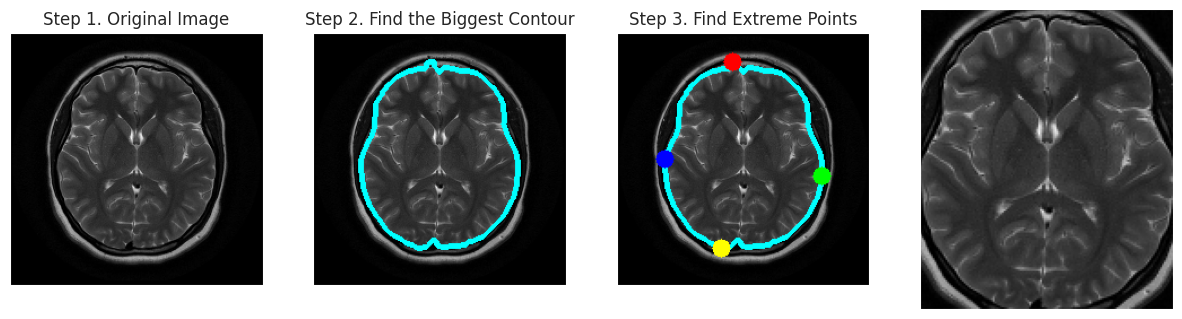

In [11]:
#Create figur efor graph
plt.figure(figsize = (15, 6))
#Select subplot to plot original image
plt.subplot(141)
#Plot original image
plt.imshow(img)
#Set a title for original image
plt.title("Step 1. Original Image")
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Select subplot to plot Biggest  Contours
plt.subplot(142)
#Plot Biggest Contours image
plt.imshow(img_cnt)
#Set a title for Biggest Contours image
plt.title("Step 2. Find the Biggest Contour")
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Select subplot to plot Extreme Points
plt.subplot(143)
#Plot extreme points
plt.imshow(img_pnt)
#Set a title for extreme points
plt.title("Step 3. Find Extreme Points")
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Select subplot to plot cropped image
plt.subplot(144)
#Plot cropped image
plt.imshow(new_img)
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])

#Dispaly images
plt.show()

### Crop Images

In [12]:
def crop_imgs(set_name, 
              add_pixels_value: int = 0,
              img_size: (int, int) = (224, 224)
             ):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        #Change size of image
        #img = cv2.resize(img,
        #                dsize = img_size,
        #                interpolation = cv2.INTER_CUBIC # This is slow but more efficient.
        #                )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
                            new_img,
                            dsize = img_size,
                            interpolation = cv2.INTER_CUBIC 
        )
        set_new.append(new_img)
 
    return np.array(set_new)

In [13]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)


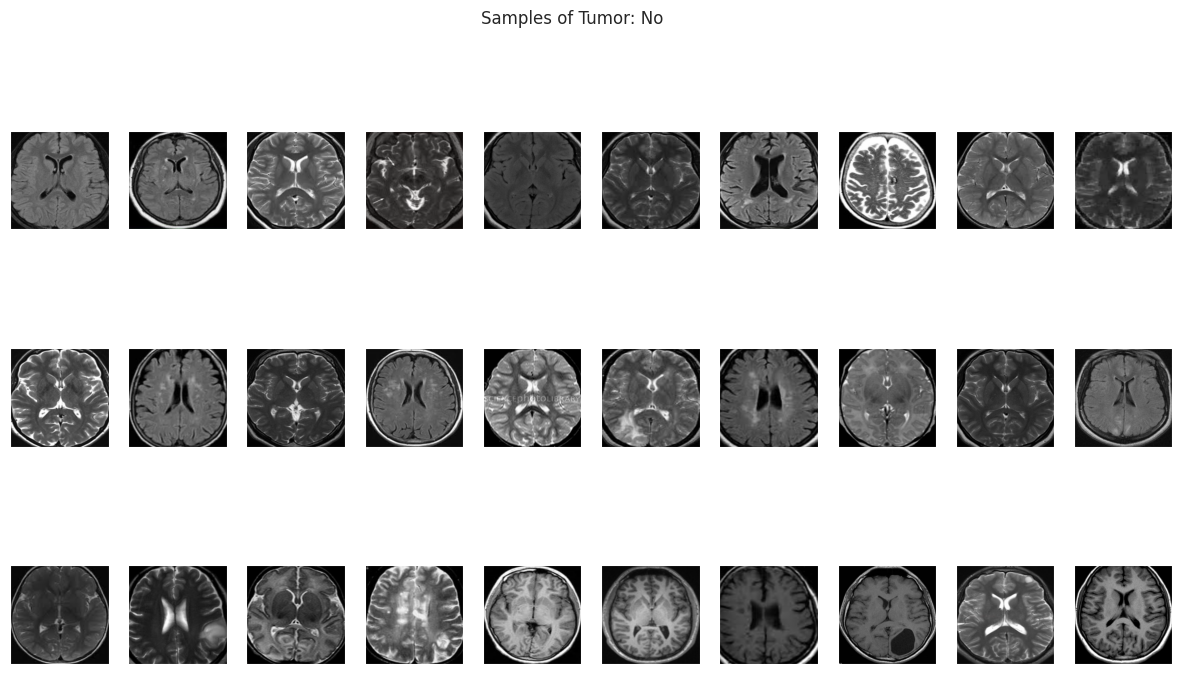

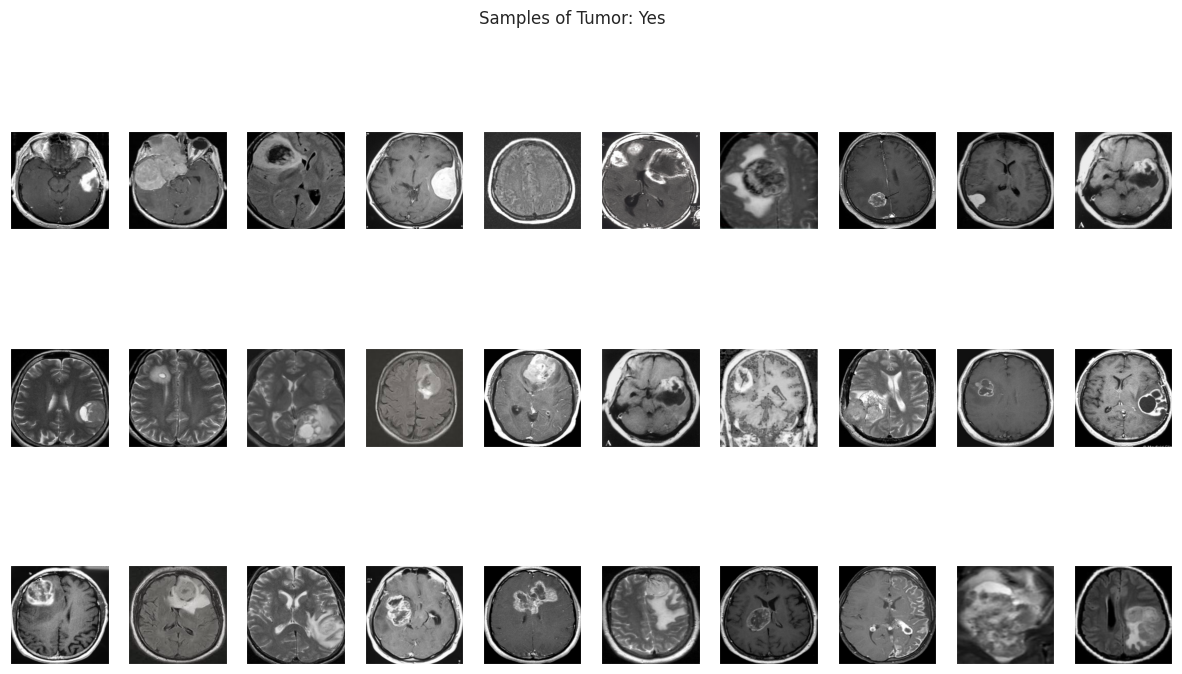

In [14]:
plot_samples(X_train_crop, y_train, 30)

## Saving new images to folder

In [15]:
#Specifies the name and location of the new directory
!mkdir Train_Crop Test_Crop Val_Crop Train_Crop/Yes Train_Crop/No Test_Crop/Yes Test_Crop/No Val_Crop/Yes Val_Crop/No
!tree -d

.
|-- Test_Crop
|   |-- No
|   `-- Yes
|-- Train_Crop
|   |-- No
|   `-- Yes
`-- Val_Crop
    |-- No
    `-- Yes

9 directories


In [16]:
def save_new_images(X, y, folder):
    """
        Save cropped images to folders
    
    """
    i = 0
    for img, imgclass in zip(X, y):
        if imgclass == 0:
            cv2.imwrite(folder + "No/" + str(i) + ".jpg", img)
        if imgclass == 1:
            cv2.imwrite(folder + "Yes/" + str(i) + ".jpg", img)
        
        i += 1
    
    print(i)

In [17]:
#Save new images to folders
save_new_images(X_train_crop, y_train, "Train_Crop/")
save_new_images(X_val_crop, y_val, "Val_Crop/")
save_new_images(X_test_crop, y_test, "Test_Crop/")

194
49
10


## Preprocessing Inputs to Models

In [18]:
def preprocessing_images(X):
    """
         Resize and apply VGG-16 preprocessing
    """
    
    set_new = []
    for img in X:
        set_new.append(tf.keras.applications.vgg16.preprocess_input(img))
    
    return np.array(set_new)

In [19]:
#Preprocess images with using VGG_16 preprocess
X_train_vgg16_preps = preprocessing_images(X_train_crop)
X_val_vgg16_preps = preprocessing_images(X_val_crop)
X_test_vgg16_preps = preprocessing_images(X_test_crop)

# Data Augmention

We have a small data set. We will increase our data set with data augmentation method. First we will generate data for the demonstration and then we will implement the model used in the demonstration

## Demonstration

In [20]:
# Create data generator for preview
demo_datagen = ImageDataGenerator(
                rotation_range = 15, # Indicates the random rotation angle range, can take values ranging from 0-180 degrees
                width_shift_range = 0.05, # Indicates the range of random horizontal scrolling and is specified as a percentage of the image width.
                height_shift_range = 0.05, #  Indicates the range of random vertical scrolling and is specified as a percentage of the image height.
                rescale = 1/255, # It is a scaling process by dividing the color numbers of the images ranging from (0-255) by 255 and moving the numbers to the range (0-1).
                shear_range = 0.05, #  The random offset interval is specified in degrees of offset angle. Float value. Works in counterclockwise direction.
                brightness_range = [0.1, 1.8], # Changes the brightness of the pictures. Values less than 1 make the image darker, while values greater than 1 make the image brighter.
                horizontal_flip = True, # When True, applies a random horizontal flip (rotation) to the image. Default is False.
                vertical_flip = True, # When True, applies a random vertical flip (rotation) to the image. Default is False.    
)

In [21]:
os.mkdir("preview")
x = X_train_crop[0]
x = x.reshape((1,) + x.shape) 

i= 0

for batch in demo_datagen.flow(
                x = x,
                batch_size = 1,
                save_to_dir = "preview",
                save_prefix = "augmention_img",
                save_format = "jpg"
    
):
    #Increase i by 1
    i += 1 

    if i > 20:
        break

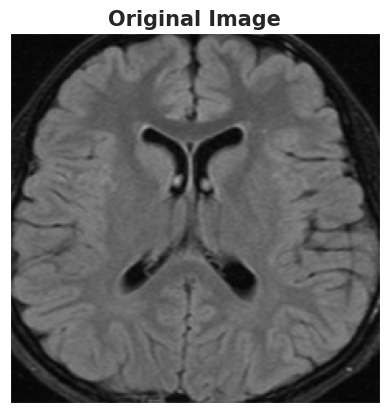

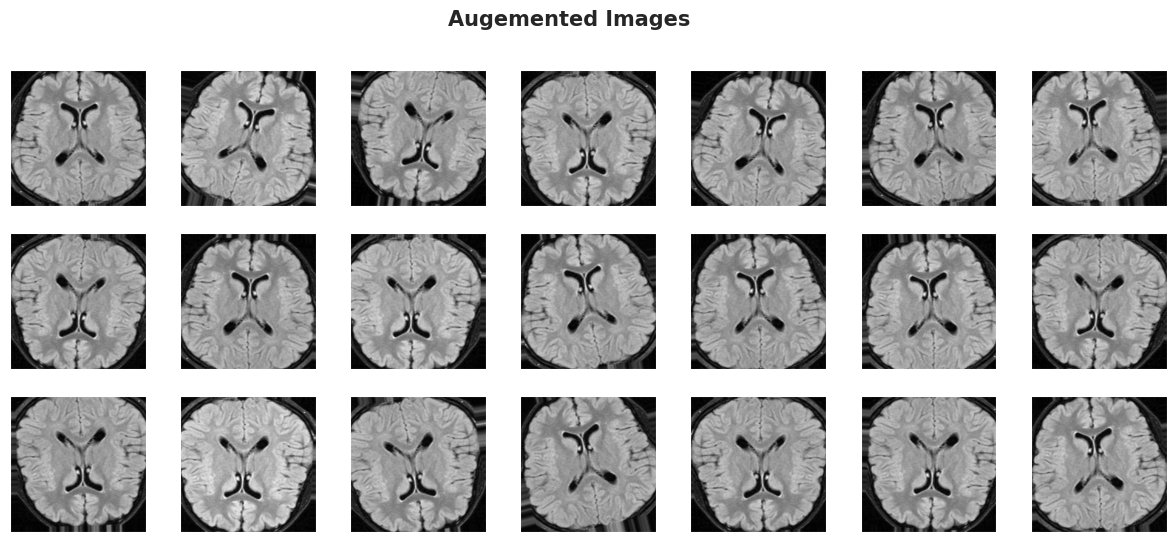

In [22]:
#Plot first image of X_train_corp
plt.imshow(X_train_crop[0])
#Set x and y labels to empty
plt.xticks([])
plt.yticks([])
#Set title for image
plt.title("Original Image", weight = "bold", fontsize = 15)
#Display image
plt.show()


#Create figure and axes for augemented images
plt.figure(figsize = (15, 6))

for i, img in enumerate(os.listdir("preview/")):
    #Read the image
    img = cv2.imread(os.path.join("preview", img))
    #Change color space of image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Select subplot for image
    plt.subplot(3, 7, i + 1)
    #Plot image
    plt.imshow(img)
    #Set x and y labels to empty
    plt.xticks([])
    plt.yticks([])
    
    if i > 3* 7:
        break

# Set a title for augemented images
plt.suptitle("Augemented Images", weight = "bold", fontsize = 15)
# Display image
plt.show()

In [23]:
#Remove preview files
!rm -rf preview/

## Apply

In [24]:
Train_dir = "Train_Crop/"
Val_dir = "Val_Crop/"

In [25]:
def create_data_generator(model_name: str,
                         Train_dir = Train_dir,
                         Val_dir = Val_dir):
    
    
    """
        Creates  data generator by selecting preprocessing_function according to model name
    
    """
    
    if model_name == "VGG16":
        preprocessing_function = tf.keras.applications.vgg16.preprocess_input
        
    elif model_name == "Resnet50":
        preprocessing_function = tf.keras.applications.resnet50.preprocess_input
        
    #Create datagen for corped train set
    train_datagen = ImageDataGenerator(
                    rotation_range = 15, # Indicates the random rotation angle range, can take values ranging from 0-180 degrees
                    width_shift_range = 0.05, # Indicates the range of random horizontal scrolling and is specified as a percentage of the image width.
                    height_shift_range = 0.05, #  Indicates the range of random vertical scrolling and is specified as a percentage of the image height.
                    #rescale = 1/255, # It is a scaling process by dividing the color numbers of the images ranging from (0-255) by 255 and moving the numbers to the range (0-1).
                    shear_range = 0.05, #  The random offset interval is specified in degrees of offset angle. Float value. Works in counterclockwise direction.
                    brightness_range = [0.5, 1.5], # Changes the brightness of the pictures. Values less than 1 make the image darker, while values greater than 1 make the image brighter.
                    horizontal_flip = True, # When True, applies a random horizontal flip (rotation) to the image. Default is False.
                    vertical_flip = True, # When True, applies a random vertical flip (rotation) to the image. Default is False. ,
                    preprocessing_function = preprocessing_function
    )

    #Create datagen for test set. No data will be generated for the test set and val set. Only preprocessing will be done
    test_datagen = ImageDataGenerator(
            preprocessing_function = preprocessing_function

    )

    #Generate data for train set
    train_generator = train_datagen.flow_from_directory(
                            directory = Train_dir,
                            color_mode = "rgb",
                            target_size = img_size,
                            batch_size = 32,
                            class_mode = "binary",
                            seed = config.seed,
                            shuffle = True

    )

    #Generate data for val set
    val_generator = test_datagen.flow_from_directory(
                        directory = Val_dir,
                        color_mode = "rgb",
                        target_size = img_size,
                        batch_size = 16,
                        class_mode = "binary",
                        #seed = config.seed,
                        shuffle = False
    )
        
    return train_generator, val_generator

# Model

In [26]:
def build_model(
                base_model = tf.keras.applications,
                **layers,
                
):
    """
        Return depp learning model with layers
    
    """
    
    model = Sequential()
    model.add(base_model)
    for _, item in layers.items():
        for layer in item:
            model.add(layer)
    
    return model
    

In [27]:
flatten_layer = layers.Flatten()
first_dense_layer = layers.Dense(256, activation = "relu", kernel_regularizer = l2(0.01))
second_dense_layer = layers.Dense(256, activation = "relu", kernel_regularizer = l2(0.01))
dropout_layer = layers.Dropout(rate = 0.5)
output_layer = layers.Dense(1, activation  = "sigmoid")

In [28]:
#Define epoch
EPOCHS = 50
#Specify early stopping conditions
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6,
    restore_best_weights = True
)

## VGG16 Model

In [29]:
#Create data generator for VGG16 model
train_generator_vgg16, val_generator_vgg16 = create_data_generator("VGG16")

Found 194 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [30]:
#load vgg16 model
base_model_vgg16 = VGG16(
            weights = config.vgg16_dir,
            #weights = "imagenet",
            include_top = False, # Whether to include the 3 fully-connected layers at the top of the network.
            input_shape = img_size + (3,)
)
#Adjust model to not trainable
base_model_vgg16.trainable = False
#Summary of model
#base_model_vgg16.summary()

In [31]:
#Build model
model = build_model(base_model = base_model_vgg16,
                   layers = [
                       flatten_layer,
                       first_dense_layer,
                       second_dense_layer,
                       dropout_layer,
                       output_layer]
                   )

In [32]:
#Compile model
model.compile(
        loss = "binary_crossentropy",
        optimizer = RMSprop(lr=1e-4),
        metrics = ["accuracy"]

)
#Summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21203521 (80.89 MB)
Trainable params: 6488

In [33]:
#fit a model
history_vgg16 = model.fit(
    x = train_generator_vgg16,
    epochs=EPOCHS,
    #steps_per_epoch = 50,
    validation_data=val_generator_vgg16,
    #validation_steps = 25,
    callbacks=[es],
    verbose = 1,
    shuffle = False
)

Epoch 1/50


I0000 00:00:1715848379.500491     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 14s 918ms/step - loss: 12585.1201 - accuracy: 0.5361 - val_loss: 70075.0469 - val_accuracy: 0.3878
Epoch 2/50
7/7 [==============================] - 3s 352ms/step - loss: 155.2775 - accuracy: 0.5567 - val_loss: 21821.5254 - val_accuracy: 0.5918
Epoch 3/50
7/7 [==============================] - 3s 390ms/step - loss: 62454.1172 - accuracy: 0.6753 - val_loss: 58092.0820 - val_accuracy: 0.5714
Epoch 4/50
7/7 [==============================] - 3s 374ms/step - loss: 29231.6211 - accuracy: 0.6289 - val_loss: 59010.4805 - val_accuracy: 0.6327
Epoch 5/50
7/7 [==============================] - 3s 374ms/step - loss: 80.9272 - accuracy: 0.7165 - val_loss: 44697.2812 - val_accuracy: 0.6735
Epoch 6/50
7/7 [==============================] - 3s 376ms/step - loss: 11317.9082 - accuracy: 0.7062 - val_loss: 41557.9180 - val_accuracy: 0.7347
Epoch 7/50
7/7 [==============================] - 3s 365ms/step - loss: 21633.1133 - accuracy: 0.7474 - val_loss: 22467.0430 - 

## Resnet 50

#Create data generator for resnet50 model
train_generator_resnet50, val_generator_resnet50 = create_data_generator("Resnet50")

load resnet50 model
base_model_resnet50 = ResNet50(
            weights = config.resnet50_dir,
            #weights = "imagenet",
            include_top = False, # Whether to include the 3 fully-connected layers at the top of the network.
            input_shape = img_size + (3,)
)
#Adjust model to not trainable
base_model_resnet50.trainable = False
#Summary of model
base_model_resnet50.summary()

#Build model
model = build_model(base_model = base_model_resnet50,
                   layers = [
                       flatten_layer,
                       first_dense_layer,
                       second_dense_layer,
                       dropout_layer,
                       output_layer]
                   )

#Compile model
model.compile(
        loss = "binary_crossentropy",
        optimizer = RMSprop(lr=1e-5),
        metrics = ["accuracy"]

)
#Summary of model
model.summary()

#fit a model
history_resnet50 = model.fit(
    x = train_generator_resnet50,
    epochs=EPOCHS,
    #steps_per_epoch = 50,
    validation_data=val_generator_resnet50,
    #validation_steps = 25,
    callbacks=[es],
    verbose = 1,
    shuffle = False
)